# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.2 Correction of inconsistent entries in the Teranet dataset

---

This notebook describes Step 2.2 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.2 focuses on the correction of inconsistent entries in the Teranet dataset. Cleanup plan is presented below.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for the Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.

## Cleanup plan

1. Convert column names to lower case
2. Fix inconsistent capitalizations for values in columns:
    * `municipality`
    * `street_name`
    * `street_designation`
    * `postal_code` (do not show problems, preventive measure)
3. Remove column `province`
4. Investigate missing values
5. Remove column `street_suffix`
5. Fix inconsistent entries in columns:
    * `unitno`
    * `street_name`
    * `street_designaction`
    * `street_direction`
    * `municipality`

## Import dependencies

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time

sns.set()

In [2]:
data_path = '../../data/teranet/'
os.listdir(data_path)

['Teranet_with_DA_cols.csv', 'HHSaleHistory.csv']

## Load Teranet data

In [3]:
t = time()
#df = pd.read_csv(data_path + 'Teranet_with_DA_cols.csv',
#                 parse_dates=['registration_date'])
df = pd.read_csv(data_path + 'Teranet_with_DA_cols.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


----- DataFrame loaded
in 14.28 seconds
with 6,803,691 rows
and 18 columns
-- Column names:
 Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'OBJECTID', 'DAUID',
       'CSDNAME'],
      dtype='object')


## Step 1: convert column names to lower case

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['lro_num', 'pin', 'consideration_amt', 'registration_date',
       'postal_code', 'province', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_suffix', 'street_number', 'x', 'y', 'objectid', 'dauid',
       'csdname'],
      dtype='object')

## Step 2: fix inconsistent capitalizations
Inconsistent capitalizations are fixed for values in the following columns: 
* `unitno`
* `street_name`
* `street_designaction`
* `street_direction`
* `municipality`

In [5]:
t = time()
df['municipality'] = df['municipality'].str.title()
df['street_name'] = df['street_name'].str.title()
df['street_designation'] = df['street_designation'].str.capitalize()
df['postal_code'] = df['postal_code'].str.upper()
elapsed = time() - t
print("Capitalizations were fixed! Took {0:,.2f} seconds.".format(elapsed))

Capitalizations were fixed! Took 8.69 seconds.


## Step 3: Remove column `province`

In [6]:
df = df.drop('province', axis=1)
print("Column 'province' was removed from the dataset.")

Column 'province' was removed from the dataset.


## Step 4: Investigate missing values

In [7]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6803691 entries, 0 to 6803690
Data columns (total 17 columns):
lro_num               6803691 non-null int64
pin                   6803691 non-null int64
consideration_amt     6803691 non-null float64
registration_date     6803691 non-null object
postal_code           6233082 non-null object
unitno                1571830 non-null float64
street_name           6598317 non-null object
street_designation    6211313 non-null object
street_direction      653205 non-null object
municipality          6799681 non-null object
street_suffix         43 non-null float64
street_number         6594322 non-null float64
x                     6803691 non-null float64
y                     6803691 non-null float64
objectid              6803691 non-null int64
dauid                 6803691 non-null int64
csdname               6803691 non-null object
dtypes: float64(6), int64(4), object(7)
memory usage: 882.4+ MB


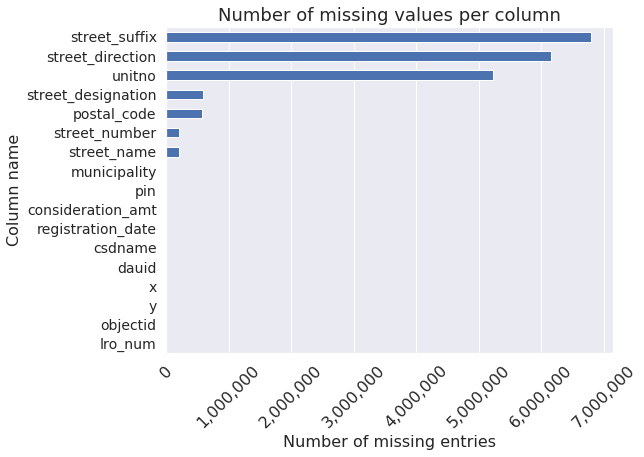

In [8]:
na_count = df.isnull().sum().sort_values()

f, ax = plt.subplots(1, figsize=(8, 6))
na_count.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Number of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("Number of missing entries", fontsize=16)
plt.savefig('results/teranet_na_count.png', dpi=400, bbox_inches='tight')

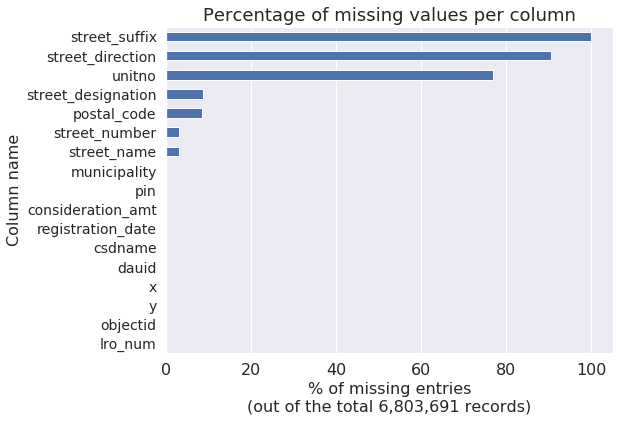

In [9]:
na_perc = df.isnull().sum().sort_values() / len(df) * 100

f, ax = plt.subplots(1, figsize=(8, 6))
na_perc.plot(kind='barh', ax=ax)
ax.grid(axis='y')
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Percentage of missing values per column", fontsize=18)
ax.set_ylabel("Column name", fontsize=16)
ax.set_xlabel("% of missing entries\n(out of the total {0:,} records)"
              .format(len(df)), fontsize=16)
plt.savefig('results/teranet_na_perc.png', dpi=400, bbox_inches='tight')

## Step 5: Remove column `street_suffix`
Since 99.99994% of the values in column `street_suffix` are missing, it has been removed from the dataset.

In [10]:
df = df.drop('street_suffix', axis=1)
print("Column 'street_suffix' was removed from the dataset.")

Column 'street_suffix' was removed from the dataset.


## Step 6: 

Column `postal_code` has been validated to contain the correct data format (Canadian postal codes).

Inconsistent entries are fixed in the following columns:
* `unitno`
* `street_name`
* `street_designaction`
* `street_direction`
* `municipality`

### Validate consistency of column `postal_code`
570'609 values are missing, the rest follow the correct data format.

In [11]:
df['postal_code'].str.match('^[A-Z]\d[A-Z]\d[A-Z]\d$')\
    .value_counts(dropna=False)

True    6233082
NaN      570609
Name: postal_code, dtype: int64

### Fix values in column `unitno`

#### 1.010000e-107

In [12]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.01')
mask3 = unit_no.str.match('1.009')
df.loc[mask1 & (mask2 | mask3), 'unitno']

340618    1.010000e-107
Name: unitno, dtype: float64

In [13]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 101
df.loc[mask1 & (mask2 | mask3), 'unitno']

340618    101.0
Name: unitno, dtype: float64

#### 1.200000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '12', '120', or '1200'. All units that match this pattern have been converted to '12'.

In [14]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.199')
df.loc[mask1 & mask2, 'unitno']

3953588    1.200000e-103
3953651    1.200000e-200
3953674    1.200000e-200
3953742    1.200000e-200
3953776    1.200000e-200
3954430    1.200000e-200
3954537    1.200000e-200
3954600    1.200000e-200
3954633    1.200000e-200
3954636    1.200000e-103
3954679    1.200000e-200
3954680    1.200000e-200
3954682    1.200000e-200
3954683    1.200000e-200
3954756    1.200000e-103
3955235    1.200000e-103
Name: unitno, dtype: float64

In [15]:
df.loc[mask1 & mask2, 'unitno'] = 12
df.loc[mask1 & mask2, 'unitno']

3953588    12.0
3953651    12.0
3953674    12.0
3953742    12.0
3953776    12.0
3954430    12.0
3954537    12.0
3954600    12.0
3954633    12.0
3954636    12.0
3954679    12.0
3954680    12.0
3954682    12.0
3954683    12.0
3954756    12.0
3955235    12.0
Name: unitno, dtype: float64

#### 2.000000e-/+x
>It is impossible to tell, if this erratic unit number corresponds to '2', '20', or '200'. All units that match this pattern have been converted to '2'.

In [16]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('2')
mask3 = unit_no.str.match('1.99')
df.loc[mask1 & (mask2 | mask3), 'unitno']

803793      2.000000e-22
804383      2.000000e-22
804389      2.000000e-22
976890     2.000000e+105
980143     2.000000e+155
980174     2.000000e+155
985930     2.000000e+105
1319468     2.000000e-06
1319615     2.000000e-05
1320010     2.000000e-06
1745134     2.000000e+18
1745135     2.000000e+19
1745136     2.000000e+21
1746261     2.000000e+18
1746262     2.000000e+19
1746263     2.000000e+21
2898062    2.000000e-123
2901764    2.000000e-123
2902654    2.000000e-123
4334081     2.000000e-12
4334231     2.000000e-12
4334306     2.000000e-12
Name: unitno, dtype: float64

In [17]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 2
df.loc[mask1 & (mask2 | mask3), 'unitno']

803793     2.0
804383     2.0
804389     2.0
976890     2.0
980143     2.0
980174     2.0
985930     2.0
1319468    2.0
1319615    2.0
1320010    2.0
1745134    2.0
1745135    2.0
1745136    2.0
1746261    2.0
1746262    2.0
1746263    2.0
2898062    2.0
2901764    2.0
2902654    2.0
4334081    2.0
4334231    2.0
4334306    2.0
Name: unitno, dtype: float64

#### 1.100000e-201
>It is impossible to tell, if this erratic unit number corresponds to '11', '110', or '1100'. All units that match this pattern have been converted to '11'.

In [18]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.1')
mask3 = unit_no.str.match('1.09')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953610    1.100000e-201
3953628    1.100000e-201
3953668    1.100000e-201
3954463    1.100000e-201
3954481    1.100000e-201
3954512    1.100000e-201
3954772    1.100000e-201
3954773    1.100000e-201
3954774    1.100000e-201
3955395    1.100000e-201
3955397    1.100000e-201
3955398    1.100000e-201
Name: unitno, dtype: float64

In [19]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 11
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953610    11.0
3953628    11.0
3953668    11.0
3954463    11.0
3954481    11.0
3954512    11.0
3954772    11.0
3954773    11.0
3954774    11.0
3955395    11.0
3955397    11.0
3955398    11.0
Name: unitno, dtype: float64

#### 1.700000e-06
>It is impossible to tell, if this erratic unit number corresponds to '17', '170', or '1700'. All units that match this pattern have been converted to '17'.

In [20]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.7')
mask3 = unit_no.str.match('1.69')
df.loc[mask1 & (mask2 | mask3), 'unitno']

1288104    0.000002
1288472    0.000002
Name: unitno, dtype: float64

In [21]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 17
df.loc[mask1 & (mask2 | mask3), 'unitno']

1288104    17.0
1288472    17.0
Name: unitno, dtype: float64

#### 1.800000e-19
>It is impossible to tell, if this erratic unit number corresponds to '18', '180', or '1800'. All units that match this pattern have been converted to '18'.

In [22]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1.8')
mask3 = unit_no.str.match('1.79')
df.loc[mask1 & (mask2 | mask3), 'unitno']

4939849    1.800000e-19
Name: unitno, dtype: float64

In [23]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 18
df.loc[mask1 & (mask2 | mask3), 'unitno']

4939849    18.0
Name: unitno, dtype: float64

#### 3.300000e-33
>It is impossible to tell, if this erratic unit number corresponds to '33', '330', or '3300'. All units that match this pattern have been converted to '33'.

In [24]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('3.3')
mask3 = unit_no.str.match('3.29')
df.loc[mask1 & (mask2 | mask3), 'unitno']

410169    3.300000e-33
410499    3.300000e-33
410506    3.300000e-33
Name: unitno, dtype: float64

In [25]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 33
df.loc[mask1 & (mask2 | mask3), 'unitno']

410169    33.0
410499    33.0
410506    33.0
Name: unitno, dtype: float64

#### 6.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '6', '60', or '600'. All units that match this pattern have been converted to '6'.

In [26]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('6')
mask3 = unit_no.str.match('5.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

2900912     6.000000e-22
2902554     6.000000e-22
3953612    6.000000e-104
3953616    6.000000e-104
3953676    6.000000e-201
3953705    6.000000e-201
3953716    6.000000e-201
3953724    6.000000e-201
3953772    6.000000e-201
3954405    6.000000e-201
3954429    6.000000e-201
3954470    6.000000e-201
3954490    6.000000e-201
3954517    6.000000e-104
3954610    6.000000e-201
3954626    6.000000e-104
3954660    6.000000e-104
3954662    6.000000e-104
3954717    6.000000e-201
3954718    6.000000e-201
3954719    6.000000e-201
3954720    6.000000e-201
3954721    6.000000e-201
3955433    6.000000e-104
3955435    6.000000e-104
Name: unitno, dtype: float64

In [27]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 6
df.loc[mask1 & (mask2 | mask3), 'unitno']

2900912    6.0
2902554    6.0
3953612    6.0
3953616    6.0
3953676    6.0
3953705    6.0
3953716    6.0
3953724    6.0
3953772    6.0
3954405    6.0
3954429    6.0
3954470    6.0
3954490    6.0
3954517    6.0
3954610    6.0
3954626    6.0
3954660    6.0
3954662    6.0
3954717    6.0
3954718    6.0
3954719    6.0
3954720    6.0
3954721    6.0
3955433    6.0
3955435    6.0
Name: unitno, dtype: float64

#### 5.000000e-x
>It is impossible to tell, if this erratic unit number corresponds to '5', '50', or '500'. All units that match this pattern have been converted to '5'.

In [28]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('5')
mask3 = unit_no.str.match('4.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953583    5.000000e-103
3953659    5.000000e-102
3953682    5.000000e-103
3953778    5.000000e-102
3954459    5.000000e-103
3954479    5.000000e-103
3954545    5.000000e-102
3954631    5.000000e-102
3954750    5.000000e-102
3954752    5.000000e-102
3954822    5.000000e-103
3954823    5.000000e-103
4287802     5.000000e-06
4287803     5.000000e-06
Name: unitno, dtype: float64

In [29]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 5
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953583    5.0
3953659    5.0
3953682    5.0
3953778    5.0
3954459    5.0
3954479    5.0
3954545    5.0
3954631    5.0
3954750    5.0
3954752    5.0
3954822    5.0
3954823    5.0
4287802    5.0
4287803    5.0
Name: unitno, dtype: float64

#### 1.000000e-/+21
>It is impossible to tell, if this erratic unit number corresponds to '1', '10', or '100'. All units that match this pattern have been converted to '1'.

In [30]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('1')
mask3 = unit_no.str.match('0.9')
id_list = [3953792, 3954603, 3954834]
mask4 = unit_no.index.isin(id_list)
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

1745078     1.000000e+21
1745138     1.000000e+18
1745139     1.000000e+20
1745140     1.000000e+22
1745141     1.000000e+25
1745142     1.000000e+27
1745145     1.000000e+19
1745146     1.000000e+17
1745147     1.000000e+21
1745161     1.000000e+26
1745163     1.000000e+23
1745186     1.000000e+17
1745195     1.000000e+16
1745321     1.000000e+19
1745437     1.000000e+17
1745438     1.000000e+19
1745439     1.000000e+21
1745440     1.000000e+23
1745528     1.000000e+26
1745667     1.000000e+26
1746217     1.000000e+20
1746218     1.000000e+27
1746219     1.000000e+22
1746220     1.000000e+25
1746221     1.000000e+18
1746441     1.000000e+17
2908723     1.000000e-10
2908791     1.000000e-10
2908927     1.000000e-10
2909068     1.000000e-10
3822265     1.000000e-05
3822266     1.000000e-05
3822267     1.000000e-05
3822268     1.000000e-05
3822269     1.000000e-05
3953792    1.000000e-101
3954603    1.000000e-101
3954834    1.000000e-101
4989609     1.000000e-20
4989611     1.000000e-20


In [31]:
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno'] = 1
df.loc[mask1 & (mask2 | mask3) | mask4, 'unitno']

1745078    1.0
1745138    1.0
1745139    1.0
1745140    1.0
1745141    1.0
1745142    1.0
1745145    1.0
1745146    1.0
1745147    1.0
1745161    1.0
1745163    1.0
1745186    1.0
1745195    1.0
1745321    1.0
1745437    1.0
1745438    1.0
1745439    1.0
1745440    1.0
1745528    1.0
1745667    1.0
1746217    1.0
1746218    1.0
1746219    1.0
1746220    1.0
1746221    1.0
1746441    1.0
2908723    1.0
2908791    1.0
2908927    1.0
2909068    1.0
3822265    1.0
3822266    1.0
3822267    1.0
3822268    1.0
3822269    1.0
3953792    1.0
3954603    1.0
3954834    1.0
4989609    1.0
4989611    1.0
4989636    1.0
Name: unitno, dtype: float64

#### 9.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '9', '90', or '900'. All units that match this pattern have been converted to '9'.

In [32]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('9')
mask3 = unit_no.str.match('8.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953784    9.000000e-104
3954609    9.000000e-104
3954768    9.000000e-104
3954955    9.000000e-104
3955042    9.000000e-104
3956086    9.000000e-104
3956539    9.000000e-104
Name: unitno, dtype: float64

In [33]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 9
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953784    9.0
3954609    9.0
3954768    9.0
3954955    9.0
3955042    9.0
3956086    9.0
3956539    9.0
Name: unitno, dtype: float64

#### 4.000000e-104
>It is impossible to tell, if this erratic unit number corresponds to '4', '40', or '400'. All units that match this pattern have been converted to '4'.

In [34]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
mask2 = unit_no.str.match('4')
mask3 = unit_no.str.match('3.9')
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953713    4.000000e-104
3954624    4.000000e-104
3954754    4.000000e-104
3955982    4.000000e-104
Name: unitno, dtype: float64

In [35]:
df.loc[mask1 & (mask2 | mask3), 'unitno'] = 4
df.loc[mask1 & (mask2 | mask3), 'unitno']

3953713    4.0
3954624    4.0
3954754    4.0
3955982    4.0
Name: unitno, dtype: float64

#### 8.000000e-206
>It is impossible to tell, if this erratic unit number corresponds to '8', '80', or '800'. All units that match this pattern have been converted to '8'.

In [36]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.contains('e')
df.loc[mask1, 'unitno']

3252381    8.000000e-206
Name: unitno, dtype: float64

In [37]:
df.loc[mask1, 'unitno'] = 8
df.loc[mask1, 'unitno']

3252381    8.0
Name: unitno, dtype: float64

#### 0.01

In [38]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.01')
df.loc[mask1, 'unitno']

15864    0.01
79209    0.01
79401    0.01
79466    0.01
80108    0.01
Name: unitno, dtype: float64

In [39]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

15864    1.0
79209    1.0
79401    1.0
79466    1.0
80108    1.0
Name: unitno, dtype: float64

#### 0.37

In [40]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.37')
df.loc[mask1, 'unitno']

836947    0.37
839733    0.37
851318    0.37
859826    0.37
865485    0.37
Name: unitno, dtype: float64

In [41]:
df.loc[mask1, 'unitno'] = 37
df.loc[mask1, 'unitno']

836947    37.0
839733    37.0
851318    37.0
859826    37.0
865485    37.0
Name: unitno, dtype: float64

#### 0.000815

In [42]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.000815')
df.loc[mask1, 'unitno']

4449760    0.000815
4449761    0.000815
4451595    0.000815
4451596    0.000815
Name: unitno, dtype: float64

In [43]:
df.loc[mask1, 'unitno'] = 815
df.loc[mask1, 'unitno']

4449760    815.0
4449761    815.0
4451595    815.0
4451596    815.0
Name: unitno, dtype: float64

#### 0.033

In [44]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.033')
df.loc[mask1, 'unitno']

853092    0.033
Name: unitno, dtype: float64

In [45]:
df.loc[mask1, 'unitno'] = 33
df.loc[mask1, 'unitno']

853092    33.0
Name: unitno, dtype: float64

#### 0.24

In [46]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.24')
df.loc[mask1, 'unitno']

3419792    0.24
3420014    0.24
3420280    0.24
3420497    0.24
Name: unitno, dtype: float64

In [47]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

3419792    24.0
3420014    24.0
3420280    24.0
3420497    24.0
Name: unitno, dtype: float64

#### 0.2

In [48]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.2')
df.loc[mask1, 'unitno']

1319349    0.2
3234526    0.2
3234604    0.2
3234681    0.2
4333955    0.2
4333977    0.2
4334044    0.2
4334046    0.2
4334048    0.2
4334051    0.2
4334095    0.2
4334132    0.2
4334151    0.2
4334191    0.2
4334193    0.2
4334202    0.2
4334307    0.2
4334326    0.2
4334359    0.2
4334360    0.2
4334361    0.2
4334366    0.2
4334399    0.2
Name: unitno, dtype: float64

In [49]:
df.loc[mask1, 'unitno'] = 2
df.loc[mask1, 'unitno']

1319349    2.0
3234526    2.0
3234604    2.0
3234681    2.0
4333955    2.0
4333977    2.0
4334044    2.0
4334046    2.0
4334048    2.0
4334051    2.0
4334095    2.0
4334132    2.0
4334151    2.0
4334191    2.0
4334193    2.0
4334202    2.0
4334307    2.0
4334326    2.0
4334359    2.0
4334360    2.0
4334361    2.0
4334366    2.0
4334399    2.0
Name: unitno, dtype: float64

#### 0.003

In [50]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.003')
df.loc[mask1, 'unitno']

4334036    0.003
4334059    0.003
4334110    0.003
4334131    0.003
4334172    0.003
4334213    0.003
4334316    0.003
4334327    0.003
4334343    0.003
Name: unitno, dtype: float64

In [51]:
df.loc[mask1, 'unitno'] = 3
df.loc[mask1, 'unitno']

4334036    3.0
4334059    3.0
4334110    3.0
4334131    3.0
4334172    3.0
4334213    3.0
4334316    3.0
4334327    3.0
4334343    3.0
Name: unitno, dtype: float64

#### 0.04

In [52]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.04')
df.loc[mask1, 'unitno']

4334115    0.04
4334303    0.04
Name: unitno, dtype: float64

In [53]:
df.loc[mask1, 'unitno'] = 4
df.loc[mask1, 'unitno']

4334115    4.0
4334303    4.0
Name: unitno, dtype: float64

#### 0.001

In [54]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.001')
df.loc[mask1, 'unitno']

2611651    0.001
2612401    0.001
2612402    0.001
2612406    0.001
2612736    0.001
2612737    0.001
2612738    0.001
Name: unitno, dtype: float64

In [55]:
df.loc[mask1, 'unitno'] = 1
df.loc[mask1, 'unitno']

2611651    1.0
2612401    1.0
2612402    1.0
2612406    1.0
2612736    1.0
2612737    1.0
2612738    1.0
Name: unitno, dtype: float64

#### 0.0026

In [56]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.0026')
df.loc[mask1, 'unitno']

2898643    0.0026
2900742    0.0026
2902337    0.0026
Name: unitno, dtype: float64

In [57]:
df.loc[mask1, 'unitno'] = 26
df.loc[mask1, 'unitno']

2898643    26.0
2900742    26.0
2902337    26.0
Name: unitno, dtype: float64

#### 0.0024

In [58]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.0024')
df.loc[mask1, 'unitno']

1288106    0.0024
1288473    0.0024
Name: unitno, dtype: float64

In [59]:
df.loc[mask1, 'unitno'] = 24
df.loc[mask1, 'unitno']

1288106    24.0
1288473    24.0
Name: unitno, dtype: float64

#### 0.66

In [60]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.66')
df.loc[mask1, 'unitno']

3861714    0.66
3862038    0.66
3862261    0.66
3868526    0.66
3870335    0.66
Name: unitno, dtype: float64

In [61]:
df.loc[mask1, 'unitno'] = 66
df.loc[mask1, 'unitno']

3861714    66.0
3862038    66.0
3862261    66.0
3868526    66.0
3870335    66.0
Name: unitno, dtype: float64

#### 0.83

In [62]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('0.83')
df.loc[mask1, 'unitno']

1067331    0.83
1067875    0.83
1069031    0.83
Name: unitno, dtype: float64

In [63]:
df.loc[mask1, 'unitno'] = 83
df.loc[mask1, 'unitno']

1067331    83.0
1067875    83.0
1069031    83.0
Name: unitno, dtype: float64

#### 3.01

In [64]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3.01$')
df.loc[mask1, 'unitno']

1927295    3.01
1927296    3.01
1927297    3.01
1927298    3.01
1927363    3.01
1927364    3.01
1927365    3.01
1927366    3.01
Name: unitno, dtype: float64

In [65]:
df.loc[mask1, 'unitno'] = 301
df.loc[mask1, 'unitno']

1927295    301.0
1927296    301.0
1927297    301.0
1927298    301.0
1927363    301.0
1927364    301.0
1927365    301.0
1927366    301.0
Name: unitno, dtype: float64

#### 1.5

In [66]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.5$')
df.loc[mask1, 'unitno']

801960    1.5
803259    1.5
Name: unitno, dtype: float64

In [67]:
df.loc[mask1, 'unitno'] = 15
df.loc[mask1, 'unitno']

801960    15.0
803259    15.0
Name: unitno, dtype: float64

#### 1.6

In [68]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.6$')
df.loc[mask1, 'unitno']

801961    1.6
803262    1.6
Name: unitno, dtype: float64

In [69]:
df.loc[mask1, 'unitno'] = 16
df.loc[mask1, 'unitno']

801961    16.0
803262    16.0
Name: unitno, dtype: float64

#### 4.2

In [70]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4.2$')
df.loc[mask1, 'unitno']

6239629    4.2
6244112    4.2
Name: unitno, dtype: float64

In [71]:
df.loc[mask1, 'unitno'] = 42
df.loc[mask1, 'unitno']

6239629    42.0
6244112    42.0
Name: unitno, dtype: float64

#### 7.9

In [72]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^7.9$')
df.loc[mask1, 'unitno']

2994453    7.9
2995955    7.9
Name: unitno, dtype: float64

In [73]:
df.loc[mask1, 'unitno'] = 79
df.loc[mask1, 'unitno']

2994453    79.0
2995955    79.0
Name: unitno, dtype: float64

#### 1.9

In [74]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^1.9$')
df.loc[mask1, 'unitno']

2734867    1.9
2735282    1.9
2735589    1.9
Name: unitno, dtype: float64

In [75]:
df.loc[mask1, 'unitno'] = 19
df.loc[mask1, 'unitno']

2734867    19.0
2735282    19.0
2735589    19.0
Name: unitno, dtype: float64

#### 9.5

In [76]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^9.5$')
df.loc[mask1, 'unitno']

2672326    9.5
2673367    9.5
2675542    9.5
2675544    9.5
Name: unitno, dtype: float64

In [77]:
df.loc[mask1, 'unitno'] = 95
df.loc[mask1, 'unitno']

2672326    95.0
2673367    95.0
2675542    95.0
2675544    95.0
Name: unitno, dtype: float64

#### 0.02, 0.002, and 0.0002

In [78]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^0')
mask2 = unit_no.str.contains('2')
df.loc[mask1 & mask2, 'unitno']

1319359    0.0020
1319553    0.0200
1319601    0.0002
1320397    0.0200
Name: unitno, dtype: float64

In [79]:
df.loc[mask1 & mask2, 'unitno'] = 2
df.loc[mask1 & mask2, 'unitno']

1319359    2.0
1319553    2.0
1319601    2.0
1320397    2.0
Name: unitno, dtype: float64

#### 4.7

In [80]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^4.7$')
df.loc[mask1, 'unitno']

853093    4.7
Name: unitno, dtype: float64

In [81]:
df.loc[mask1, 'unitno'] = 47
df.loc[mask1, 'unitno']

853093    47.0
Name: unitno, dtype: float64

#### 6.5

In [82]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^6.5$')
df.loc[mask1, 'unitno']

1962991    6.5
Name: unitno, dtype: float64

In [83]:
df.loc[mask1, 'unitno'] = 65
df.loc[mask1, 'unitno']

1962991    65.0
Name: unitno, dtype: float64

#### 3.5

In [84]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^3.5$')
df.loc[mask1, 'unitno']

1962995    3.5
Name: unitno, dtype: float64

In [85]:
df.loc[mask1, 'unitno'] = 35
df.loc[mask1, 'unitno']

1962995    35.0
Name: unitno, dtype: float64

#### 16.9

In [86]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16.9$')
df.loc[mask1, 'unitno']

1963015    16.9
1963083    16.9
1964150    16.9
Name: unitno, dtype: float64

In [87]:
df.loc[mask1, 'unitno'] = 169
df.loc[mask1, 'unitno']

1963015    169.0
1963083    169.0
1964150    169.0
Name: unitno, dtype: float64

#### 10.4

In [88]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^10.4$')
df.loc[mask1, 'unitno']

1963052    10.4
1964021    10.4
Name: unitno, dtype: float64

In [89]:
df.loc[mask1, 'unitno'] = 104
df.loc[mask1, 'unitno']

1963052    104.0
1964021    104.0
Name: unitno, dtype: float64

#### 17.2

In [90]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^17.2$')
df.loc[mask1, 'unitno']

1963129    17.2
1964272    17.2
Name: unitno, dtype: float64

In [91]:
df.loc[mask1, 'unitno'] = 172
df.loc[mask1, 'unitno']

1963129    172.0
1964272    172.0
Name: unitno, dtype: float64

#### 16.2

In [92]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16.2$')
df.loc[mask1, 'unitno']

1964881    16.2
Name: unitno, dtype: float64

In [93]:
df.loc[mask1, 'unitno'] = 162
df.loc[mask1, 'unitno']

1964881    162.0
Name: unitno, dtype: float64

#### 16.1

In [94]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16.1$')
df.loc[mask1, 'unitno']

1964945    16.1
Name: unitno, dtype: float64

In [95]:
df.loc[mask1, 'unitno'] = 161
df.loc[mask1, 'unitno']

1964945    161.0
Name: unitno, dtype: float64

#### 16.5

In [96]:
unit_no = df['unitno'].astype('str')
mask1 = unit_no.str.match('^16.5$')
df.loc[mask1, 'unitno']

1964951    16.5
Name: unitno, dtype: float64

In [97]:
df.loc[mask1, 'unitno'] = 165
df.loc[mask1, 'unitno']

1964951    165.0
Name: unitno, dtype: float64

#### All erratic values in column `unitno` have been fixed
Column `unitno` can be converted to `integer` data type without any loss of information (verified below).
This will be performed upon entry of Teranet data into PostgreSQL, as Pandas library in Python [does not have](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#support-for-integer-na) an efficient representation of missing values for `integer` data type.

In [98]:
unit_no = df['unitno'].dropna().astype('int')
mask1 = unit_no != df['unitno'].dropna()
df.dropna(subset=['unitno']).loc[mask1, 'unitno']

Series([], Name: unitno, dtype: float64)

### Inconsistent values in column `street_name`
Column `street_name` has many inconsistent entries. However, since fixing all of them presents a time-intensive task, it makes more sense to perform targeted corrections in the future for particular streets of interest. At the moment, no changes to values of `street_name` have been made.

Below are some examples of inconsistent entries in column `street_name`

In [ ]:
mask1 = df['street_name'].str.contains('Bathhurst', case=False, na=False)
df[mask1]